# Main Analysis Pipeline

In [21]:
import sys
sys.path.insert(0, '../modules')
from hits import CDCHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
from root_numpy import list_branches
%load_ext memory_profiler
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter
from cylinder import CDC

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Convenience Functions

In [22]:
# The most common are stored in these notebooks
%run visualizations.ipynb
%run data_tools.ipynb

Populating the interactive namespace from numpy and matplotlib


In [23]:
def set_additional_branches(sample, row_name=None, cell_id=None, relative_time=None):
    """
    Set the trigger time and cell ID branches
    """
    if row_name:
        sample.data[row_name] = sample.geom.get_layers(sample.data[sample.flat_name])
    if cell_id:
        sample.data[cell_id] = sample.geom.get_indexes(sample.data[sample.flat_name])
    if relative_time:
        sample.data[relative_time] = sample.data[sample.time_name] - sample.data[sample.trig_name]

## Access data

In [24]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]]

## Import the Signal Hits

In [25]:
def test_labelling(hit_sample, sig_name, momentum_name, value):
    current_labels = hit_sample.get_events()[sig_name]
    momentum_magnitude = np.sqrt(np.square(hit_sample.get_events()[momentum_name+'.fX']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fY']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fZ']))
    pid_values = hit_sample.get_events()[pid_name]
    new_labels = np.logical_and(momentum_magnitude > value, pid_values == 11)
    print("Number of signal now : {}".format(sum(current_labels)))
    print("Number of signal actual : {}".format(sum(new_labels)))
    print("Number mislabelled : {}".format(hit_sample.n_hits - sum(current_labels == new_labels)))

### Make cuts

In [26]:
def remove_coincidence(hit_samp, remove_hits=True):
    # Sort by local score name
    hit_samp.sort_hits(lcl_scr_name, ascending=False)
    all_hits_keep = hit_samp.get_measurement(hit_samp.hits_index_name, only_hits=True)
    # Make a mask   
    hit_samp.data[take_hit_name][all_hits_keep.astype(int)] = 1
    # Remove the hits
    if remove_hits:
        hit_samp.trim_hits(take_hit_name, values=1)
        hit_samp.sort_hits(hit_samp.flat_name)

## Define Our Samples

In [27]:
## Branches not needed
#drift_dist_name = prefix + "DriftDist"
#turn_id_name = prefix + "TurnID"
#pid_name = prefix + "Track.fPID"
#parent_track_id_name = prefix + "Track.fParentTrackID"
#all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
#                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
#all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
#                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
#hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
#hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names

In [28]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"


## Branches to be filled
row_name = prefix +"Layers"
cell_id_name = prefix + "CellID"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"

empty_branches = [row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [29]:
these_branches = dict()
these_branches["CDC"] = [drift_name, 
                         track_id_name]
these_branches["CTH"] = None

In [30]:
file_root = "/home/five4three2/development/ICEDUST/"\
            "track-finding-yandex/data/MC4p/"

back_samples = ["MC4p_background_sample_3bunch-train_1.root",
                "MC4p_background_sample_3bunch-train_2.root",
                "MC4p_background_sample_3bunch-train_3.root",
                "MC4p_background_sample_3bunch-train_4.root"]
sig_samples = ["oa_xx_xxx_09010000-0000_xerynzb6emaf_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09110000-0000_2mdcao2ehzya_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09210000-0000_opfmr3awxs2m_user-TrkTree_000_500signal-label.root",
               "oa_xx_xxx_09310000-0000_v62e3u5ppkju_user-TrkTree_000_500signal-label.root"]

sig_samples = [
    "oa_xx_xxx_09010000-0000_xerynzb6emaf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09110000-0000_2mdcao2ehzya_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09210000-0000_opfmr3awxs2m_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09310000-0000_v62e3u5ppkju_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09410000-0000_z2p5ysva45vx_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09510000-0000_3eox62hw5ygi_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09610000-0000_7ctgq54tptae_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09710000-0000_kah3t5htgouf_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09810000-0000_a4tlhqvqnv4p_user-TrkTree_000_500signal-label.root",
    "oa_xx_xxx_09910000-0000_h6g347twij7d_user-TrkTree_000_500signal-label.root"]

sig_samples_700 = [
    "oa_xx_xxx_09010000-0000_bgd5wd5uhw2n_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09110000-0000_fiey62djp4gd_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09210000-0000_chqno3g2fxqs_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09310000-0000_paynw633hzqk_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09410000-0000_kd234xkjqddc_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09510000-0000_lpd33ym64roi_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09610000-0000_i37ocps322kr_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09710000-0000_t2l7rgghqqdq_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09810000-0000_mzoackf2gbk7_user-TrkTree_000_700signal-label.root",
    "oa_xx_xxx_09910000-0000_cbwuzp2l4inz_user-TrkTree_000_700signal-label.root"]

back_samples = [file_root + this_file for this_file in back_samples]
sig_samples = [file_root + this_file for this_file in sig_samples]

## Import the Data

In [31]:
%run data_tools.ipynb

In [32]:
train = data_import_sample(sig_samples[0], back_samples[0], 
                           these_cuts=["500","Trig","Track"],
                           branches=these_branches,
                           empty_branches=empty_branches)
set_additional_branches(train.cdc, 
                        row_name=row_name, 
                        cell_id=cell_id_name, 
                        relative_time=rel_time_name)

Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && 1 == 1 && 1 == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && 1 == 1 && 1 == 1'}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Trimming Signal Events
CTH Sig Events 3039 
CDC Sig Events 3039 
CDC Back Events 3039 


## Prepare the data

In [33]:
bins_for_plots = 50
figsize(10,5)

/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


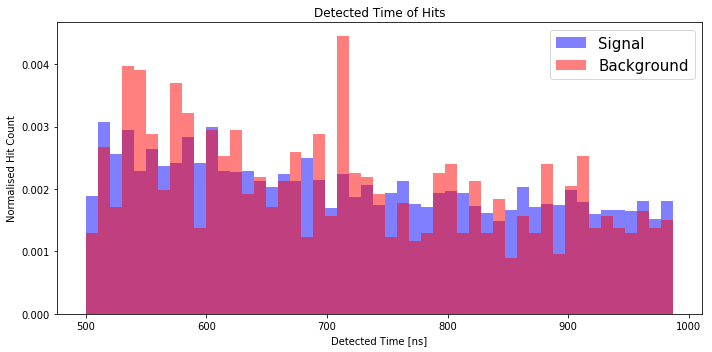

In [34]:
plot_feature( train.cth.get_signal_hits()[train.cth.time_name], 
              train.cth.get_background_hits()[train.cth.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

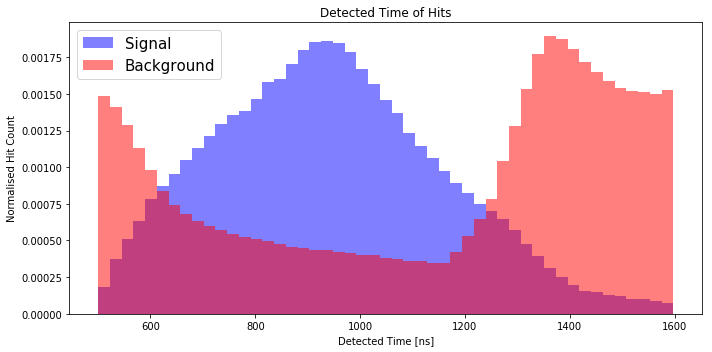

In [35]:
plot_feature( train.cdc.get_signal_hits()[train.cdc.time_name], 
              train.cdc.get_background_hits()[train.cdc.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

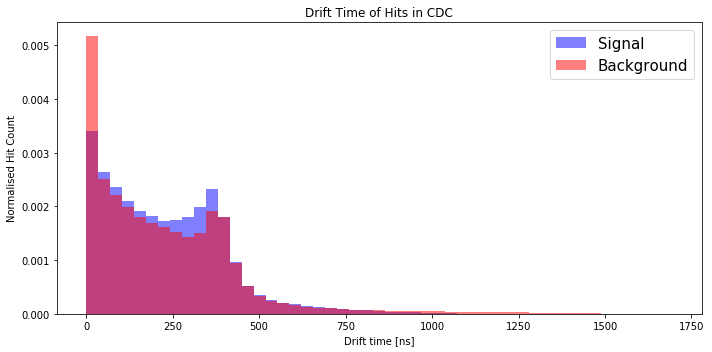

In [36]:
plot_feature( train.cdc.get_signal_hits()[drift_name], 
              train.cdc.get_background_hits()[drift_name], 
              xlabel="Drift time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Drift Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [37]:
event = 1000
print(np.unique(train.cth.get_events(event)["CTHHit.fTrigTime"]))
print(np.unique(train.cth.get_events(event)["CTHHit.fEventNumber"]))
print(np.unique(train.cdc.get_events(event)["CDCHit.fTrigTime"]))
print(np.unique(train.cdc.get_events(event)["CDCHit.fEventNumber"]))

[  0.         952.24615479]
[9046729]
[952.24615479]
[   1001 9046729]


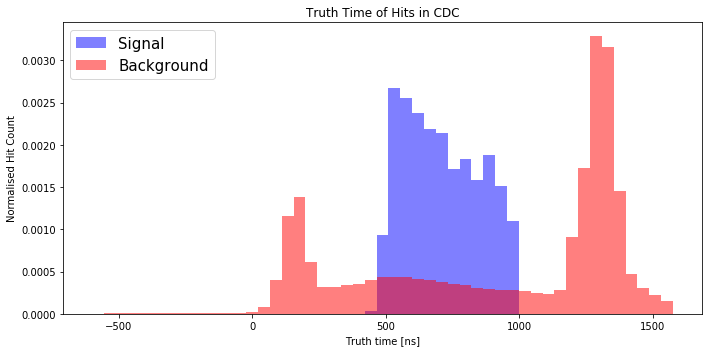

In [38]:
plot_feature( train.cdc.get_signal_hits()[train.cdc.time_name] -\
                  train.cdc.get_signal_hits()[drift_name],  
              train.cdc.get_background_hits()[train.cdc.time_name] -\
              train.cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC",  
              nbins=bins_for_plots)
show()

# Begin the Analysis

In [39]:
bins_for_plots = 50
figsize(6,4)

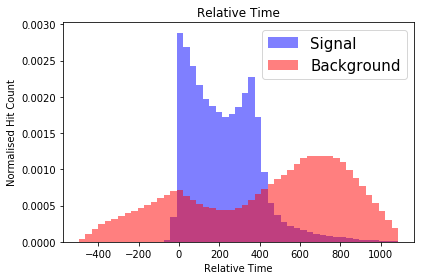

In [40]:
plot_feature( train.cdc.get_signal_hits()[rel_time_name],
              train.cdc.get_background_hits()[rel_time_name],
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

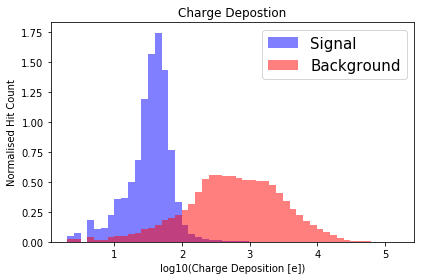

In [41]:
plot_feature( np.log10(train.cdc.get_signal_hits()[train.cdc.edep_name] + 1), 
              np.log10(train.cdc.get_background_hits()[train.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

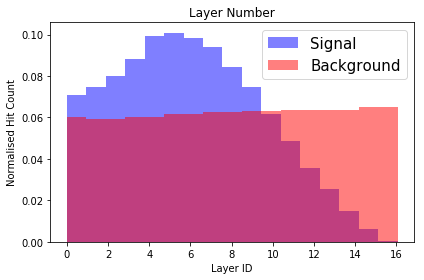

In [42]:
plot_feature( train.cdc.get_signal_hits()[row_name], 
              train.cdc.get_background_hits()[row_name], 
              xlabel="Layer ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Layer Number", 
              nbins=18)
show()

In [43]:
print(train.cdc.geom.n_points)

4482


In [44]:
sig_occ, back_occ, occ = train.cdc.get_occupancy()

Sig Occ: 84.0552813425 , Back Occ : 623.378084896
All Occ: 694.783481408, 0.155016394781
NumHits: 737.281342547
MinMultiHit: 0.0611670574729


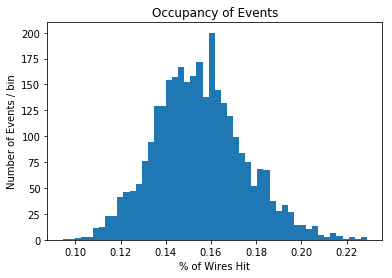

In [45]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occ)/4482., bins=50)
plt.show()

In [46]:
%run visualizations.ipynb
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


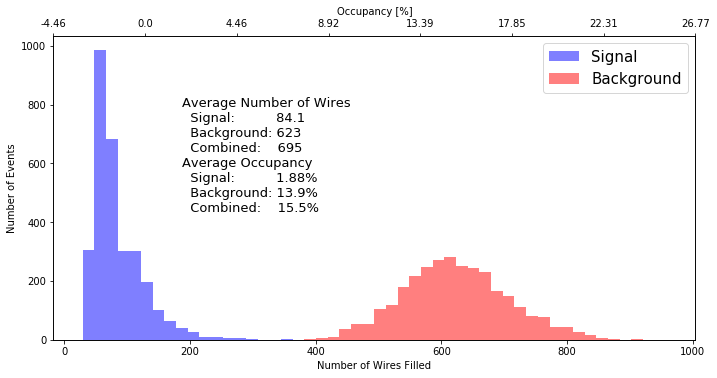

In [47]:
plot_occupancies(sig_occ, back_occ, occ,
                n_vols=4482, x_pos=0.2, y_pos=0.8)

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [48]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [49]:
# Split up the data first
from sklearn.model_selection import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = list(range(train.cdc.n_events))
rest, sample_3     = train_test_split(rest, train_size=0.54, test_size=0.36, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.33, test_size=0.66, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

In [50]:
# Get a measurement to compare
#orig_edep = np.sort(train.cdc.get_events(evt_samp[0])[train.cdc.edep_name])
#new_edep = np.sort(train.cdc.get_events(new_samples[0])[train.cdc.edep_name])

In [51]:
# Remove unused events
all_events = evt_samp[0] + evt_samp[1] + evt_samp[2]
evt_name = []
for samp in evt_samp:
    evt_name.append(np.unique(train.cdc.get_events(samp)[train.cdc.key_name]))
good_events = np.unique(train.cdc.get_events(all_events)[train.cdc.key_name])
train.cdc.trim_hits(train.cdc.key_name, values=good_events)
# Relabel the hit samples
evt_samp = []
for new_samp in evt_name:
    this_hit = train.cdc.filter_hits(train.cdc.key_name, values=new_samp)[train.cdc.hits_index_name]
    this_evt = list(np.unique(train.cdc.hits_to_events[this_hit]))
    evt_samp.append(this_evt)
# Get the hit masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

### Classify Using Local Features

In [52]:
#from rep.metaml.factory import ClassifiersFactory
#from rep.estimators import SklearnClassifier, TMVAClassifier
#from rep.report.metrics import RocAuc
from collections import OrderedDict
from sklearn.ensemble import GradientBoostingClassifier
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [53]:
# Define Data
lcl_train_features = [train.cdc.edep_name, rel_time_name, row_name]

In [54]:
factory = OrderedDict()

# Define GBDT over neighbour-level features
local_gbdt = (GradientBoostingClassifier(n_estimators=100), lcl_train_features)
# Add the GBDT
factory['Local Features'] = local_gbdt

In [55]:
# Train the classifier
for classifier, features in factory.values():
    classifier.fit(DataFrame(train.cdc.data[features][hit_masks[0]]), 
                             train.cdc.data[train.cdc.hit_type_name][hit_masks[0]])

In [56]:
train.cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fCellID
CDCHit.fHough_Score
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [57]:
# Print these predictions
train.cdc.data[lcl_scr_name] = local_gbdt[0].predict_proba(DataFrame(train.cdc.data[lcl_train_features]))[:,1]
# Invalidate the training sample
train.cdc.data[lcl_scr_name][hit_masks[0]] = -1
# remove coincidence
remove_coincidence(train.cdc)
# Get the hit masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train.cdc)

0.9888511076622655


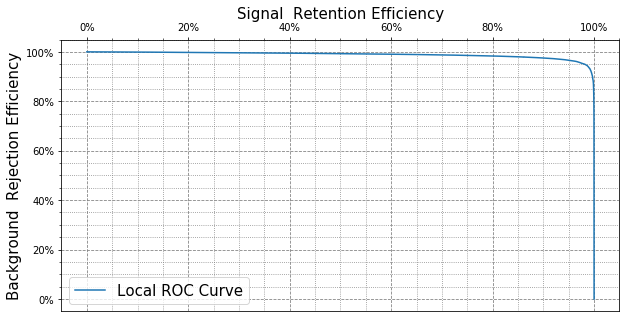

In [58]:
plot_roc_curve(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(lcl_scr_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               zoom=False, label="Local ROC Curve")
print(roc_auc_score(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(lcl_scr_name, 
                                         events=evt_samp[1]+evt_samp[2],
                                         only_hits=True)))
plt.show()

## Use Neighbour Level Features

In [59]:
# Define Data
neigh_train_features = [train.cdc.edep_name, 
                        train.cdc.edep_name + "_left",
                        train.cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        row_name]

In [60]:
# Define GBDT over neighbour-level features
neigh_gbdt = (GradientBoostingClassifier(n_estimators=100), neigh_train_features)
# Add the GBDT
factory['Neighbour and Local Features'] = neigh_gbdt

In [61]:
# Train the classifier
data = DataFrame(np.vstack(get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, evt_samp[1]) +\
                           get_measurment_and_neighbours(train.cdc, train.cdc.time_name, evt_samp[1]) +\
                          [train.cdc.data[row_name][hit_masks[1]]]).T, columns=neigh_train_features)
for classifier, features in factory.values():
    classifier.fit(data[features],train.cdc.data[train.cdc.hit_type_name][hit_masks[1]])
del data

In [62]:
# Print these predictions
train.cdc.data[ngh_scr_name] = neigh_gbdt[0].predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train.cdc, train.cdc.edep_name) +\
            get_measurment_and_neighbours(train.cdc, train.cdc.time_name) +\
            [train.cdc.data[row_name]]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train.cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.9975115288925361


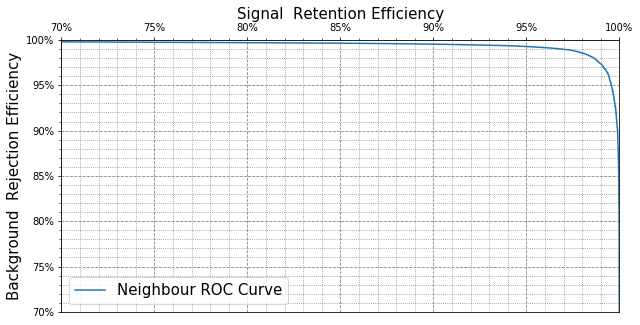

In [63]:
plot_roc_curve(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
               train.cdc.data[ngh_scr_name][hit_masks[2]], 
               zoom=True, label="Neighbour ROC Curve")
print(roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
               train.cdc.data[ngh_scr_name][hit_masks[2]]))
plt.show()

In [64]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]]
                        - train.cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [65]:
# Check the ROC score weighted by the problem weights
print(roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
                    train.cdc.data[ngh_scr_name][hit_masks[2]]))
print(roc_auc_score(train.cdc.data[train.cdc.hit_type_name][hit_masks[2]], 
                    train.cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2))

0.9975115288925361
0.1459205689764689


## Perform Hough Transform

In [66]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [67]:
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     train.cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [68]:
# Get the hough results
train.cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(train.cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

In [69]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = (GradientBoostingClassifier(n_estimators=100), track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = (GradientBoostingClassifier(n_estimators=200), [train.cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt[0].set_params(n_estimators=200)
local_gbdt[0].set_params(n_estimators=200)

# Add the classifiers
factory['Track, Local and Neighbour Features'] = hough_gbdt
factory['Energy Deposition'] = dep_gbdt

In [70]:
# Train the classifier
data = DataFrame(np.vstack(
                    get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, events=evt_samp[2]) +\
                    get_measurment_and_neighbours(train.cdc, train.cdc.time_name, events=evt_samp[2]) +\
                    [train.cdc.get_measurement(row_name, only_hits=True,flatten=True, events=evt_samp[2])] +\
                    [train.cdc.get_measurement(hgh_scr_name, only_hits=True,flatten=True, events=evt_samp[2])]).T,
                columns=track_train_features)
for classifier, features in factory.values():
    classifier.fit(data[features], 
                   train.cdc.get_measurement(train.cdc.hit_type_name, only_hits=True,flatten=True, events=evt_samp[2]))
del data

## Save the Classifiers and Training Data

In [71]:
# Save the training sample and training data
import pickle as pickle
from pandas import DataFrame

In [72]:
# Choose directory to save it to
classifiers_dir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/classifiers/"
#train_name = "batch_3_4_2500"
#test_name = "batch_5_2675"
train_name = "batch_3_2500"
test_name = "batch_4_2536"

save_class = False
load_class = False
save_test = False
load_test = False

In [73]:
if save_class:
    # Save the classifier
    pickle.dump(factory, open(classifiers_dir + "class_"+train_name+".p", "wb" ) )
    # Save the transformer 
    pickle.dump(hough_transformer, open(classifiers_dir + "hough_"+train_name+".p", "wb" ))
    # Save the training sample and remove it
    pickle.dump(train.cdc, open(classifiers_dir + "train_"+train_name+".p", "wb" ) )

In [74]:
print "Memory Usage {}".format(memory_usage())
%xdel train
print "Memory Usage {}".format(memory_usage())

Memory Usage [1464.40234375]
Memory Usage [1086.01953125]


In [75]:
if load_class:
    factory = pickle.load(open(classifiers_dir + "class_"+train_name+".p", "rb" ) )
    hough_transformer = pickle.load(open(classifiers_dir + "hough_"+train_name+".p", "rb" ) )
    local_gbdt = factory['Local Features']
    neigh_gbdt = factory['Neighbour and Local Features']
    hough_gbdt = factory['Track, Local and Neighbour Features']

In [76]:
print("Memory Usage {}".format(memory_usage()))

Memory Usage [1086.01953125]


## Test on the New Sample

In [77]:
%%memit
if load_test: 
    test_s = pickle.load(open(classifiers_dir + "test_"+test_name+".p", "rb" ) )
else:
    test_s = data_import_sample(sig_samples[1], back_samples[1], 
                              these_cuts=["500","Trig","Track"],
                              branches=these_branches,
                              empty_branches=empty_branches)
    set_additional_branches(test_s.cdc, 
                            row_name=row_name, 
                            cell_id=cell_id_name, 
                            relative_time=rel_time_name)

Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && 1 == 1 && 1 == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && 1 == 1 && 1 == 1'}
Using cuts
{ 'CDC': 'CDCHit.fDetectedTime < 1620 && CDCHit.fDetectedTime > 500 && CDCHit.fGoodTrig == 1 && CDCHit.fGoodTrack == 1',
  'CTH': 'CTHHit.fMCPos.fE < 1620 && CTHHit.fMCPos.fE > 500 && CTHHit.fGoodTrig == 1 && CTHHit.fGoodTrack == 1'}
Getting branches
{'CDC': ['CDCHit.fDriftTime', 'CDCHit.fTrack.fTrackID'], 'CTH': None}
Trimming Signal Events
CTH Sig Events 3039 
CDC Sig Events 3039 
CDC Back Events 3039 
peak memory: 1833.85 MiB, increment: 794.08 MiB


In [78]:
if load_class:
    # Define features
    lcl_train_features = [test_s.cdc.edep_name, rel_time_name, row_name]
    neigh_train_features = [test_s.cdc.edep_name, 
                        test_s.cdc.edep_name + "_left",
                        test_s.cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        row_name]
    track_train_features = neigh_train_features + [hgh_scr_name]

In [79]:
if load_test:
    _ , hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                                    only_hits=True, flatten=True)
    default = [[31.5, 34, 34.5, 2]]
    submatrices = []

    # TODO test with several radii
    for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
        # Try with default values
        hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                           sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
else: 
    # Get the local score predictions
    test_s.cdc.data[lcl_scr_name] = local_gbdt[0].predict_proba(DataFrame(test_s.cdc.data[lcl_train_features]))[:,1]
    # Remove coincident hits
    remove_coincidence(test_s.cdc)
    # Get the neighbouring score predictions
    test_s.cdc.data[ngh_scr_name] = neigh_gbdt[0].predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                [test_s.cdc.data[row_name]]).T,
            columns=neigh_train_features))[:,1]
    # Get the hough results
    test_s.cdc.data[hgh_scr_name], hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                       only_hits=True, flatten=True)
    # Test it on the last set of data
    test_s.cdc.data[trk_scr_name] = hough_gbdt[0].predict_proba(
            DataFrame(
                np.vstack(
                        get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                        get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                        [test_s.cdc.data[row_name]] +\
                        [test_s.cdc.data[hgh_scr_name]]).T,
                columns=track_train_features)
            )[:,1]

In [80]:
if save_test:
    # Save the test_sample
    pickle.dump(test_s.cdc, open(classifiers_dir + "test_"+test_name+".p", "wb" ) )

In [81]:
# Test the sample in the end
test_data = DataFrame(np.vstack(get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                           get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                           [test_s.cdc.data[row_name]] +\
                           [test_s.cdc.data[hgh_scr_name]]).T, columns=track_train_features)

In [82]:
# Test the sample
final_diagnostics = OrderedDict()
for name, (classifier, features) in factory.items():
    final_diagnostics[name] = classifier.predict_proba(test_data[features])

# Visualize The Results

In [83]:
figsize(11, 7.3333)
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [150]:
fig_scale = 2
figsize(6*fig_scale, 4*fig_scale)

save_plots = True
dpi_plots = 300
savedir = "/home/five4three2/development/ICEDUST/track-finding-yandex/images/Microsoft_AI_portfolio/"


/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/five4three2/development/miniconda3/envs/tfy2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


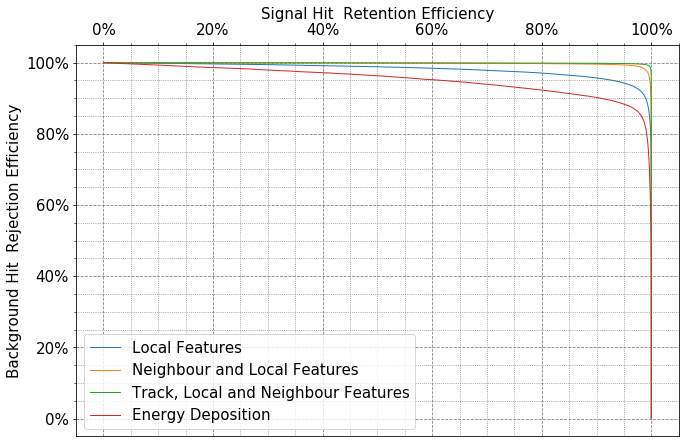

In [84]:
plot_set_font()


plot_rocs(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics, 
         names=None,
         zoom=False,
         datum_label="Hit")
plt.show()

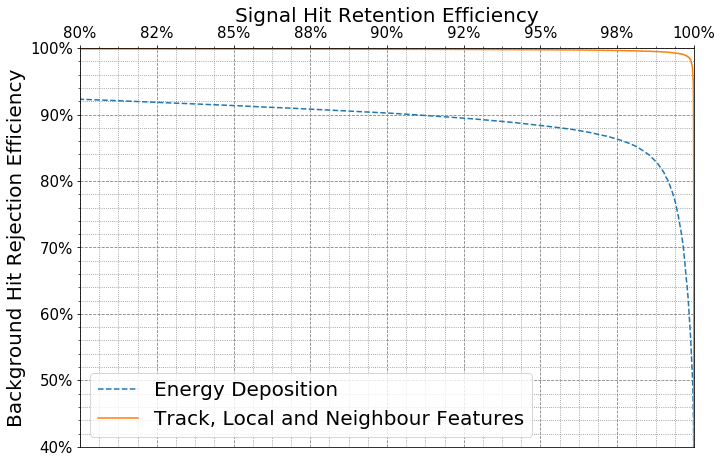

In [85]:
plot_set_font()
figsize(11, 7.3333)

plot_roc_curve(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
               final_diagnostics["Energy Deposition"][:,1], 
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[40,100],
         label="Energy Deposition",
         datum_label="Hit",
         ls="--",
         fontsize=20)
plot_roc_curve(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
               final_diagnostics["Track, Local and Neighbour Features"][:,1], 
         zoom=True,
         zoom_x_lims=[80,100],
         zoom_y_lims=[40,100],
         label="Track, Local and Neighbour Features",
         datum_label="Hit",
         fontsize=20)
plt.show()

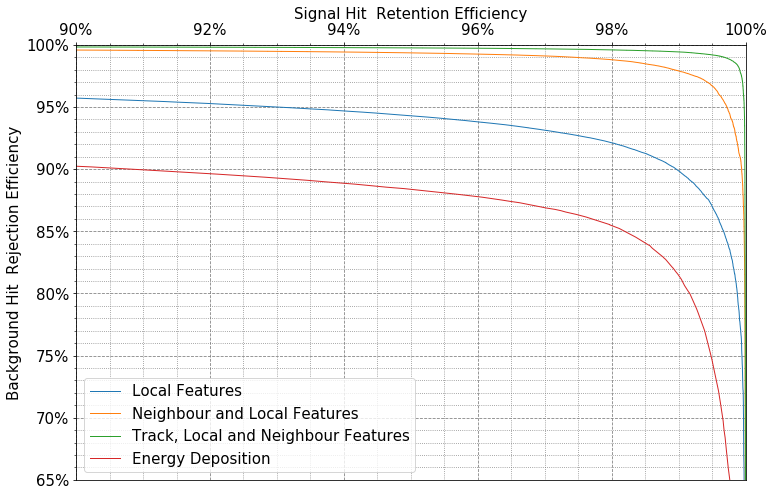

In [151]:
plot_set_font()
plot_rocs(test_s.cdc.get_measurement(test_s.cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics, 
         zoom=True,
         zoom_x_lims=[90,100],
         zoom_y_lims=[65,100],
         datum_label="Hit")

if save_plots:
    plt.savefig(savedir+"roc_curves.png", bbox_inches='tight', dpi=dpi_plots)
    
plt.show()

In [87]:
figsize(10, 5)

Sig Occ: 83.0523198421 , Back Occ : 612.198420533
All Occ: 695.250740375, 0.155120647116
NumHits: 695.250740375
MinMultiHit: 0.0


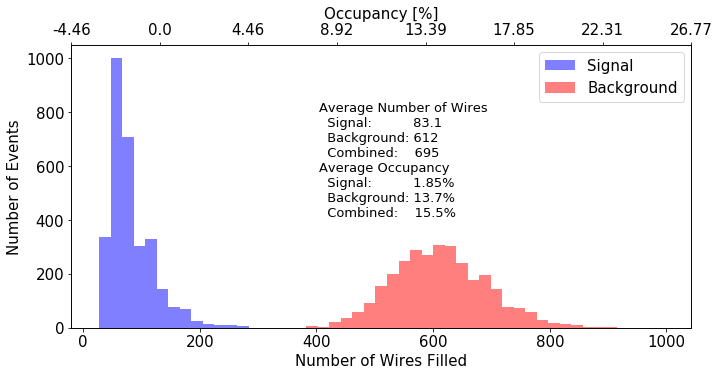

In [88]:
sig_occupy, back_occupy, occupy = test_s.cdc.get_occupancy()
plot_occupancies(sig_occupy, back_occupy, occupy, x_pos=0.4, y_pos=0.8)

In [89]:
sig_occ, back_occ, occ = list(), list(), list()
for event in range(test_s.cdc.n_events):
    #sig_occ += [sum(test_s.cdc.get_signal_hits(event)[trk_scr_name])]
    #back_occ += [sum(test_s.cdc.get_background_hits(event)[trk_scr_name])]
    #occ += [sum(test_s.cdc.get_events(event)[trk_scr_name])]
    sig_hits = test_s.cdc.get_signal_hits(event)
    sig_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=sig_hits,
                                    greater_than=0.624549)
    sig_occ += [len(np.unique(sig_hits[test_s.cdc.flat_name]))]
    bkg_hits = test_s.cdc.get_background_hits(event)
    bkg_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=bkg_hits,
                                    greater_than=0.624549)
    back_occ += [len(np.unique(bkg_hits[test_s.cdc.flat_name]))]
    all_evt_hits = test_s.cdc.get_events(event)
    all_evt_hits = test_s.cdc.filter_hits("CDCHit.fTrack_Score", 
                                    these_hits=all_evt_hits,
                                    greater_than=0.624549)
    occ += [len(np.unique(all_evt_hits[test_s.cdc.flat_name]))]  

# print some infor
avg_n_hits = np.average(test_s.cdc.event_to_n_hits)
avg_occ = np.average(occ)
print("Sig Occ: {} , Back Occ : {}".format(np.average(sig_occ), np.average(back_occ)))
print("All Occ: {}, {}".format(avg_occ, avg_occ/4482.))
print("NumHits: {}".format(avg_n_hits))
print("MinChansMultiHit: {}".format((avg_n_hits - avg_occ)/float(avg_occ)))

Sig Occ: 81.3958538993 , Back Occ : 2.45310957552
All Occ: 83.8489634748, 0.0187079347333
NumHits: 695.250740375
MinChansMultiHit: 7.29170345778


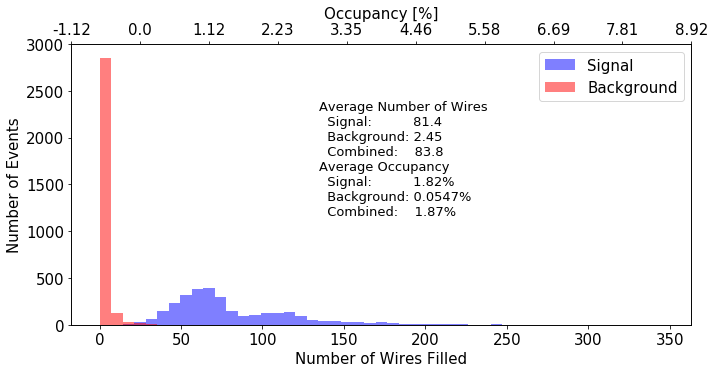

In [90]:
plot_set_font()
plot_occupancies(sig_occ, back_occ, occ, x_pos=0.4, y_pos=0.8)

In [91]:
labels = test_s.cdc.get_measurement(test_s.cdc.hit_type_name, 
                                  flatten=True)

In [92]:
%run visualizations.ipynb

Populating the interactive namespace from numpy and matplotlib


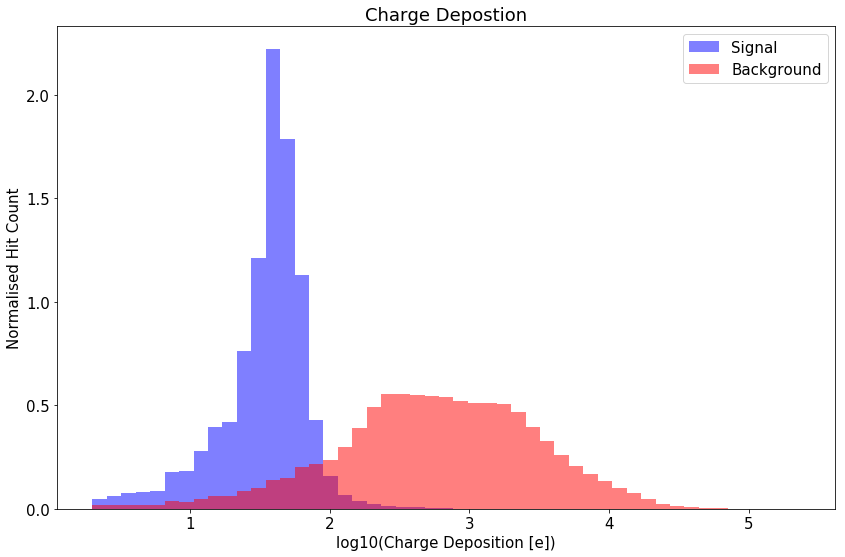

In [148]:


plot_old_classifier_line = False
plot_feature( np.log10(test_s.cdc.get_signal_hits()[test_s.cdc.edep_name] + 1), 
              np.log10(test_s.cdc.get_background_hits()[test_s.cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)

if plot_old_classifier_line:
    edep_val = 163
    bkg_edeps = test_s.cdc.get_background_hits()[test_s.cdc.edep_name]
    sig_edps = test_s.cdc.get_signal_hits()[test_s.cdc.edep_name]
    print "Background acceptance",sum(bkg_edeps < 163)/float(bkg_edeps.shape[0])
    print "Signal acceptance",sum(sig_edps < 163)/float(sig_edps.shape[0])
    plt.axvline(x=np.log10(edep_val+1), c="Orange")

if save_plots:
    plt.savefig(savedir+"charge_depo.png", bbox_inches='tight', dpi=dpi_plots)
    
show()

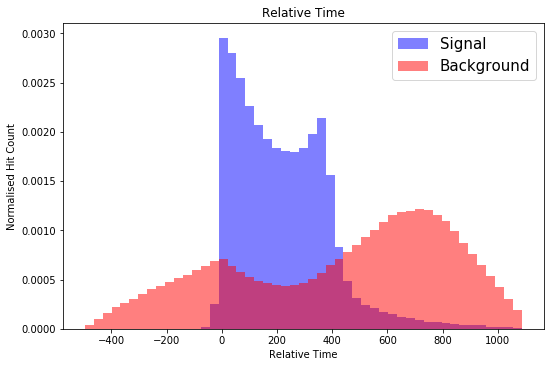

In [94]:
plot_feature( test_s.cdc.get_signal_hits()[rel_time_name],
              test_s.cdc.get_background_hits()[rel_time_name],
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

In [95]:
cdc_radii = np.array([53.0, 54.6, 56.2, 57.8, 59.4, 61.0, 62.6, 64.2, 65.8,
                      67.4, 69.0, 70.6, 72.2, 73.8, 75.4, 77.0, 78.6, 80.2])

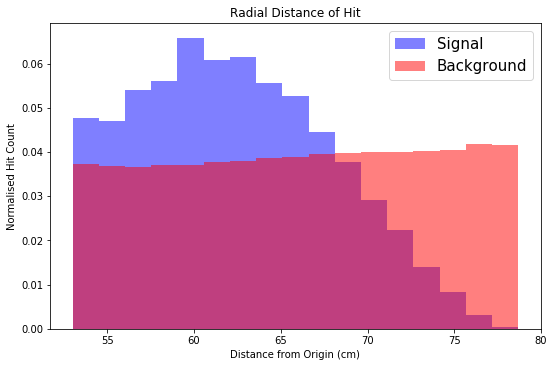

In [96]:
plot_feature( cdc_radii[test_s.cdc.get_signal_hits()[row_name].astype(int)], 
              cdc_radii[test_s.cdc.get_background_hits()[row_name].astype(int)], 
              xlabel="Distance from Origin (cm)", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Radial Distance of Hit", 
              nbins=18)
show()

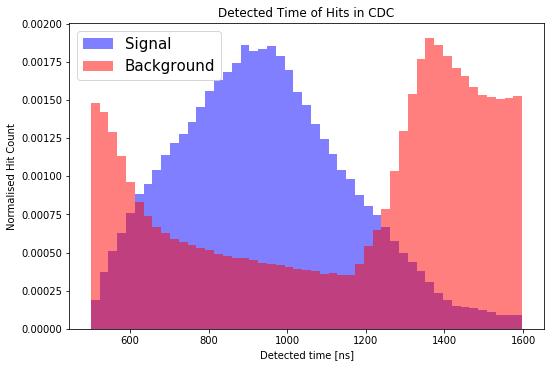

In [97]:
plot_feature( test_s.cdc.get_signal_hits()[test_s.cdc.time_name],
              test_s.cdc.get_background_hits()[test_s.cdc.time_name],
              xlabel="Detected time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

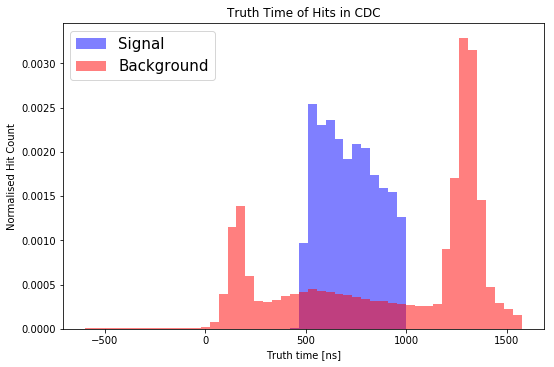

In [98]:
plot_feature( test_s.cdc.get_signal_hits()[test_s.cdc.time_name] -\
              test_s.cdc.get_signal_hits()[drift_name],  
              test_s.cdc.get_background_hits()[test_s.cdc.time_name] -\
              test_s.cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

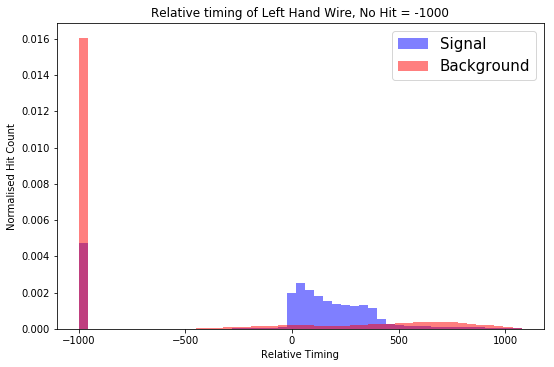

In [99]:
plot_feature(  test_s.cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 1], 
               test_s.cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 0], 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", 
              title="Relative timing of Left Hand Wire, No Hit = -1000",
              xlog=False, nbins=bins_for_plots)


show()

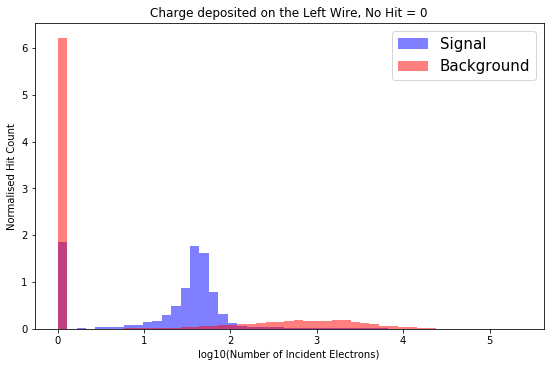

In [100]:
plot_feature(  np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 1]), 
               np.log10(test_s.cdc.get_measurement(test_s.cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 0]), 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = 0", 
              nbins=bins_for_plots)
show()

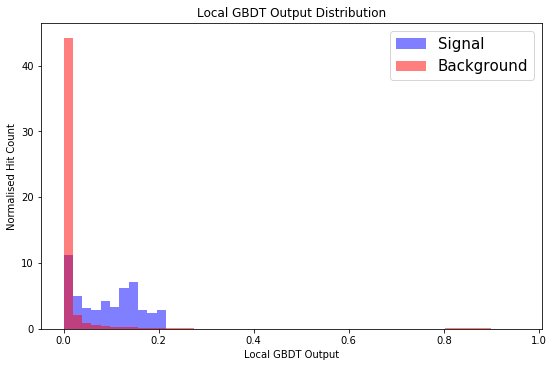

In [101]:
plot_feature( test_s.cdc.get_signal_hits()[lcl_scr_name], 
              test_s.cdc.get_background_hits()[lcl_scr_name],  
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=bins_for_plots)
show()

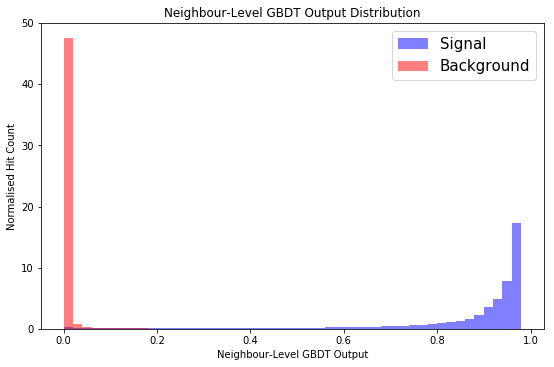

In [102]:
plot_feature( test_s.cdc.get_signal_hits()[ngh_scr_name], 
              test_s.cdc.get_background_hits()[ngh_scr_name], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=bins_for_plots)
show()

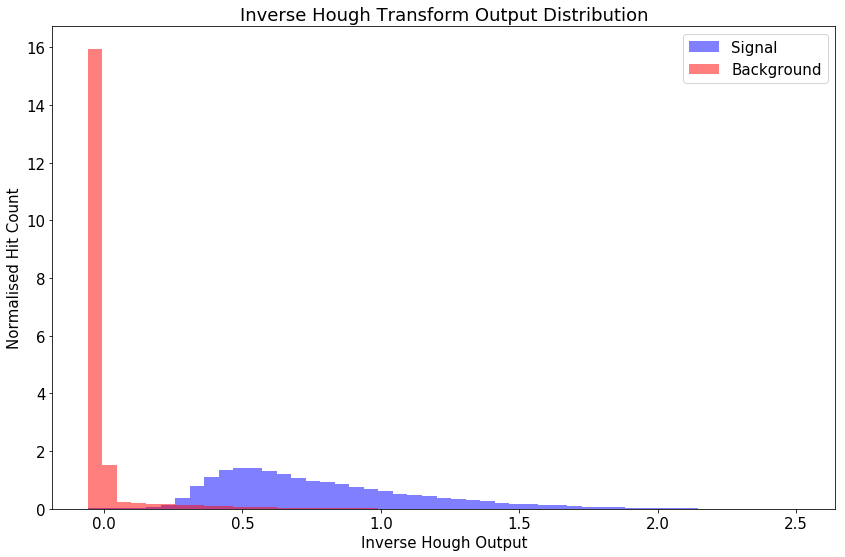

In [152]:
plot_feature( test_s.cdc.get_signal_hits()[hgh_scr_name], 
              test_s.cdc.get_background_hits()[hgh_scr_name], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Inverse Hough Transform Output Distribution", 
              nbins=bins_for_plots)

if save_plots:
    plt.savefig(savedir+"inv_hough_plot.png", bbox_inches='tight', dpi=dpi_plots)
    
    
show()

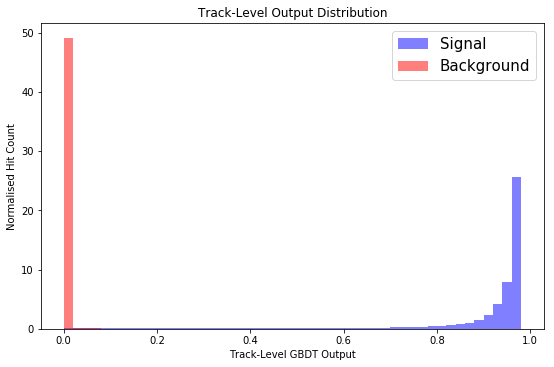

In [104]:
plot_feature( test_s.cdc.get_signal_hits()[trk_scr_name], 
              test_s.cdc.get_background_hits()[trk_scr_name],  
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Track-Level Output Distribution", 
              nbins=bins_for_plots)
show()

In [111]:
from collections import OrderedDict
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (test_s.cdc.edep_name,          "Charge"),  
            (test_s.cdc.edep_name+"_left",  "Left Charge"),  
            (test_s.cdc.edep_name+"_right", "Right Charge"),  
            (row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j'$")
    ])

In [112]:
np.arange(-1, 1, 0.25)

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75])

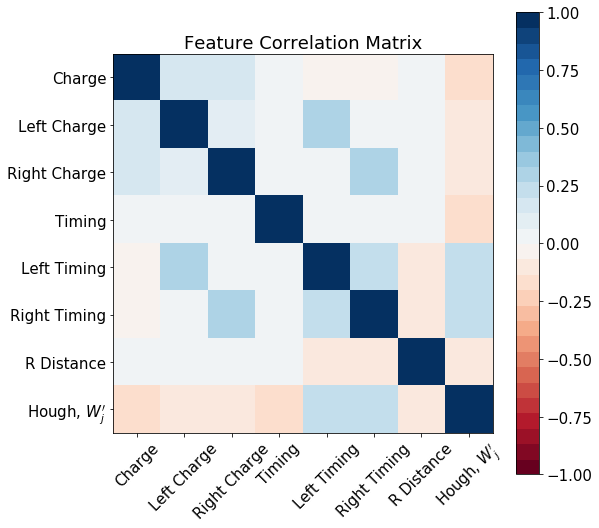

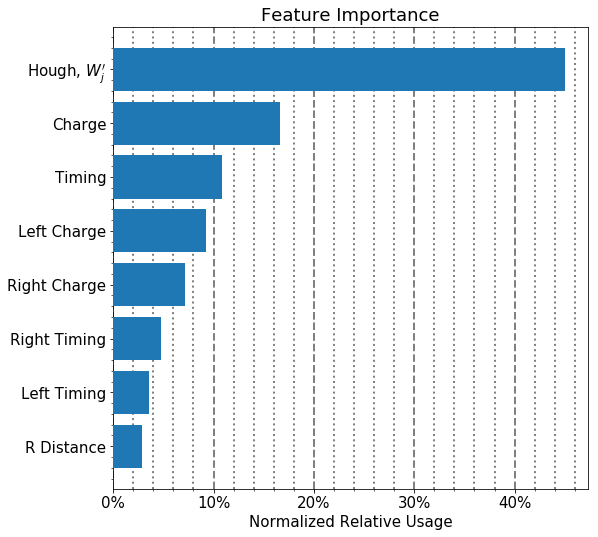

In [113]:
figsize(8.5,8.5) 
plot_feature_correlations(test_data, "Feature Correlation Matrix", feat_label_dict)
show()
plot_feature_importance(hough_gbdt, feat_label_dict)
show()

## Visualiaze the Data

In [118]:
high_hit = np.arange(test_s.cdc.n_events)[test_s.cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_s.cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(test_s.cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print(len(good_event))
print(good_event)

330
[   4   20   21   26   37   62   66   84   86   91  103  112  117  135
  140  153  155  157  169  185  205  214  215  217  228  231  242  250
  253  262  270  287  298  303  311  327  329  332  334  337  344  369
  372  387  393  394  402  404  416  420  424  427  453  454  456  472
  498  513  519  525  536  538  559  561  563  565  606  613  627  633
  635  637  644  646  684  687  688  695  701  706  719  734  737  747
  748  751  770  772  778  783  786  788  795  798  801  804  806  821
  831  838  841  848  850  876  881  887  889  904  911  918  923  957
  979  988 1004 1007 1020 1042 1044 1049 1085 1116 1117 1121 1149 1155
 1174 1178 1181 1185 1189 1221 1229 1230 1232 1243 1263 1266 1271 1307
 1313 1321 1338 1357 1377 1378 1381 1389 1416 1424 1444 1457 1458 1461
 1471 1472 1487 1488 1490 1493 1498 1521 1523 1531 1550 1551 1558 1561
 1570 1574 1575 1594 1603 1607 1613 1619 1635 1637 1640 1644 1647 1649
 1652 1655 1656 1660 1664 1676 1688 1701 1704 1706 1731 1755 1773 1779
 1

In [140]:
# Event information\
#event = 17, good, big island of hits
#event = 18, very good
event = 1
event = good_event[event]
#event = evt_samp[3][event]
add_trans = True
save = True
#dpi = None
dpi = 300
savedir = "/home/five4three2/development/ICEDUST/track-finding-yandex/images/Microsoft_AI_portfolio/"

print np.unique(test_s.cdc.get_measurement("CDCHit.fEventNumber", events=event)).astype(int)

to_plot = np.take([0,2,1], test_s.cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(test_s.cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(test_s.cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = test_s.cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)

#hough_event = evt_samp[3][event]
hough_event = event

plot_hough_image_3 = hough_images[hough_event,:hough.track.n_points] +\
                     hough_images[hough_event,hough.track.n_points:] 
plot_hough_no_rw = hough_transformer.normed_corresp.T.dot(ngh_pred_size.T).T
plot_hough_no_rw = plot_hough_no_rw[:hough.track.n_points] + plot_hough_no_rw[hough.track.n_points:]

[   3060 9110795]


705.0


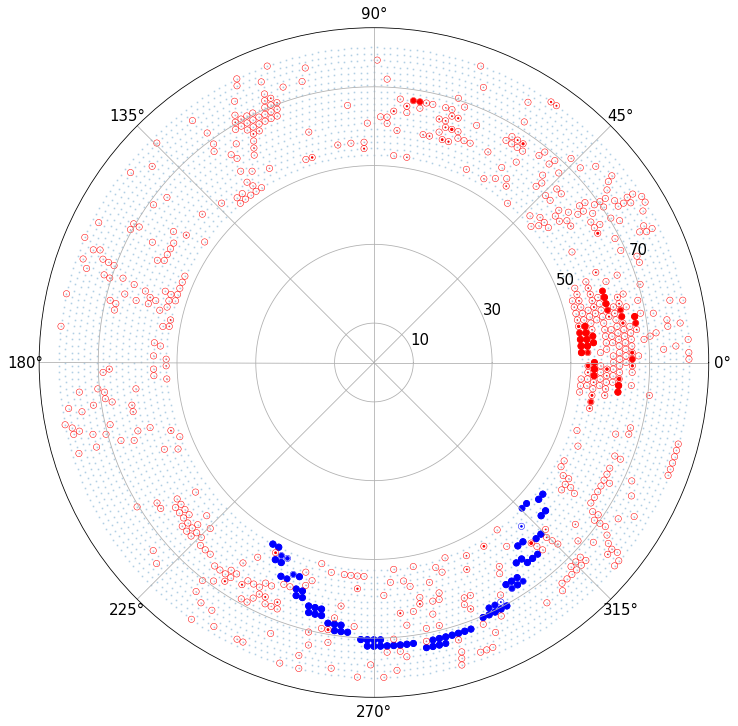

In [147]:
# First GBDT output
print(occupy[event])
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight', dpi=d)
show()

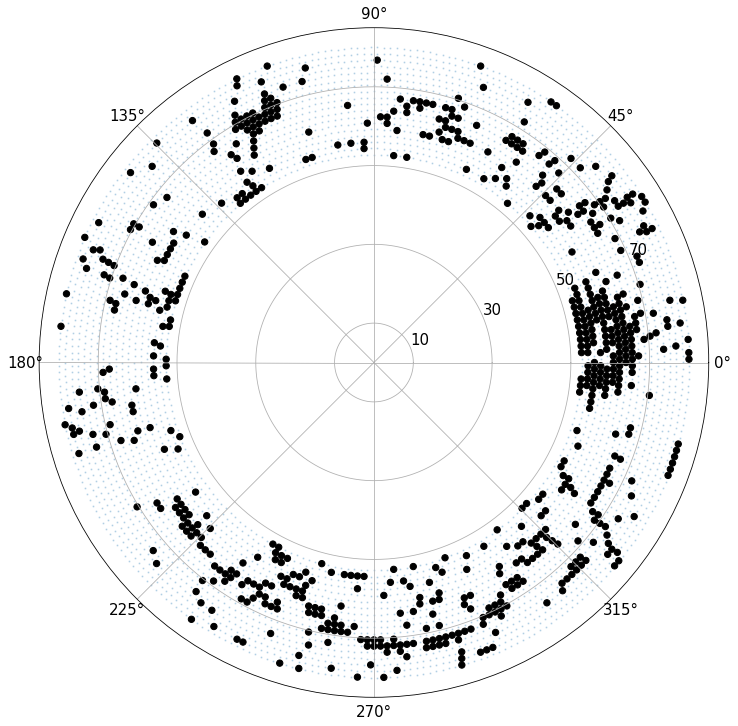

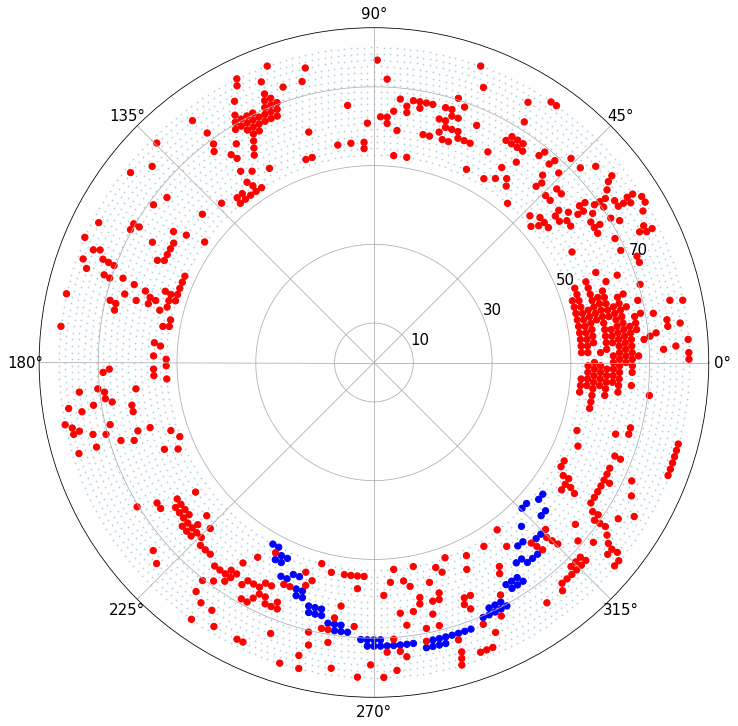

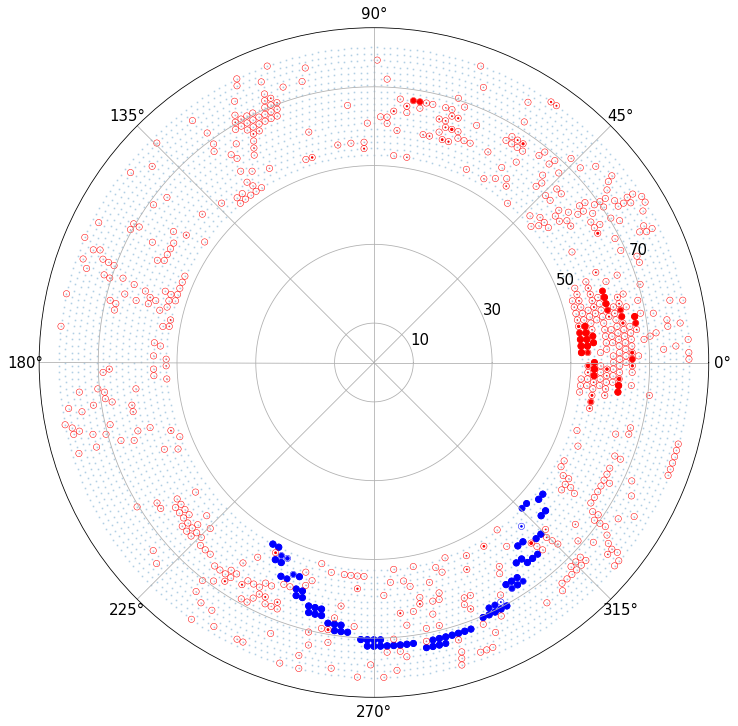

Length of draw tracks are 1752


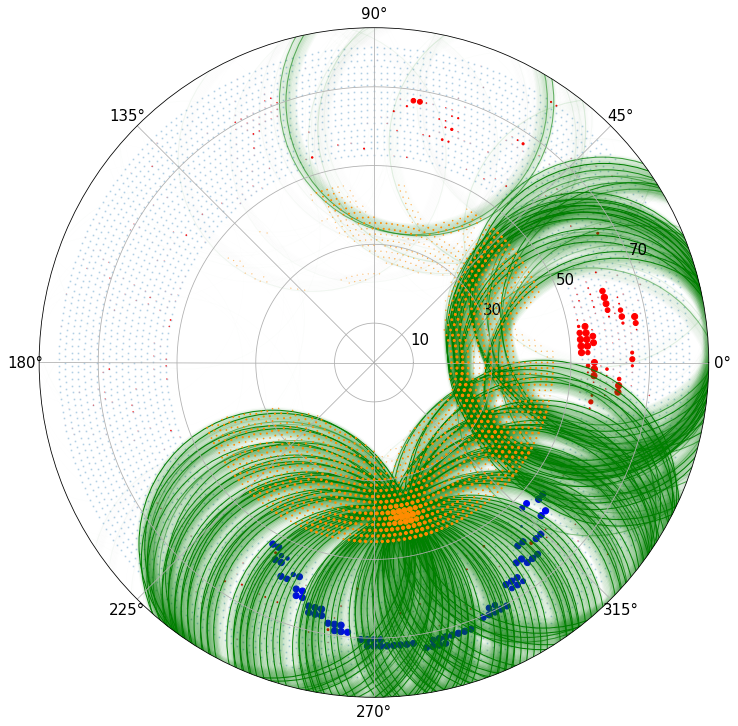

Length of draw tracks are 89


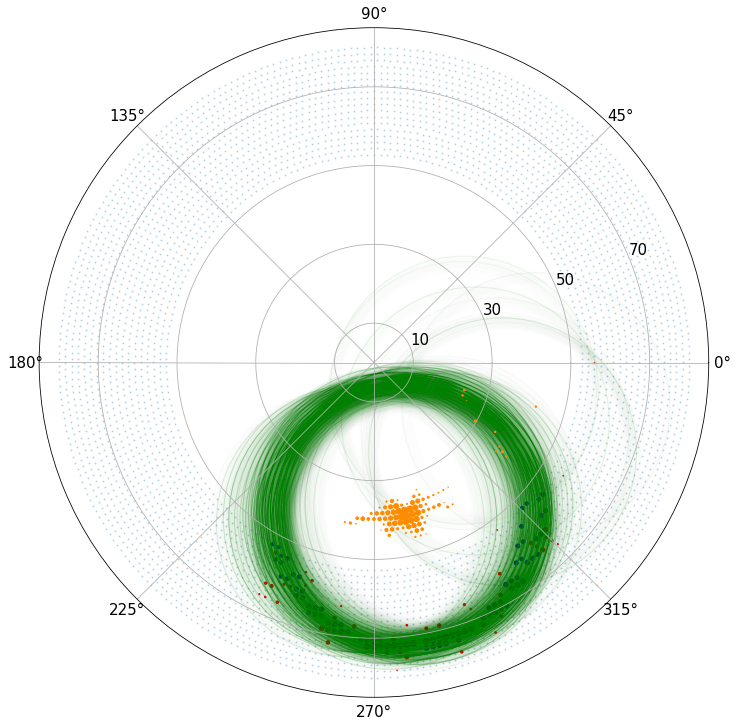

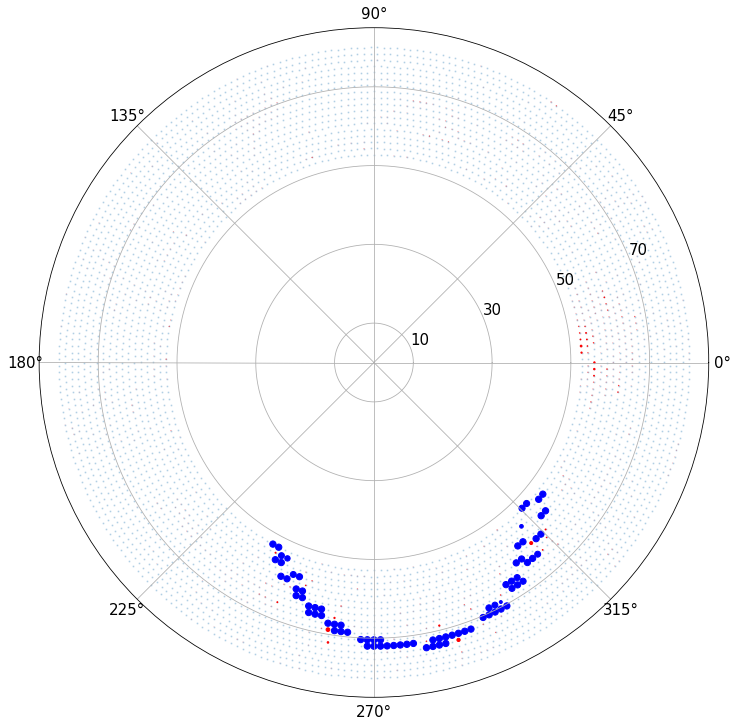

In [142]:
# Basic output
plot_output(to_plot, test_s.cdc.geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight', dpi=dpi)
show()

plot_output(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight', dpi=dpi)
show()

# First GBDT output
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight', dpi=dpi)
show()

# Hough output
plot_output(to_plot, test_s.cdc.geom, 
            size=ngh_pred_size, 
            add_transform=add_trans)
plot_add_tracks(test_s.cdc.geom, hough, 
                size=plot_norm_size(plot_hough_no_rw - np.amin(plot_hough_no_rw),40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight', dpi=dpi)
show()

# Inverse Hough output
plot_output(to_plot, test_s.cdc.geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(test_s.cdc.geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight', dpi=dpi)
show()    

# Final
plot_output(to_plot, test_s.cdc.geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight', dpi=dpi)
show()

In [130]:
from tabulate import tabulate

In [93]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print(tabulate(table, headers="firstrow"))

In [94]:
fpr, tpr, thresh = roc_curve(test_s.cdc.data["CDCHit.fIsSig"], 
          test_s.cdc.data[trk_scr_name])

print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=1)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
          0.01        0.996788  0.0828214
          0.02        0.999006  0.0140617
          0.03        0.999404  0.00554307
          0.04        0.99965   0.00316546
          0.05        0.999702  0.00208636
          0.06        0.999801  0.00149968
          0.07        0.999825  0.00111744
          0.08        0.999853  0.000867814
          0.09        0.999869  0.000723472
          0.1         0.999885  0.000617858
          0.11        0.999885  0.000534459
          0.12        0.999897  0.000473181
          0.13        0.999897  0.00041683
          0.14        0.999901  0.000368874
          0.15        0.999905  0.00033237
          0.16        0.999913  0.000301588
          0.17        0.999917  0.000279683
          0.18        0.99992   0.000259769
          0.19        0.99992   0.000244085
          0.2         0.99992   0.000237014
  Bkg Retained    Sig Retained    Threshold

In [95]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=9000, threshold_max=10000, bins=10000, steps=1)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
        0.0001        0.116717  0.99632
        0.0002        0.266953  0.994476
        0.0003        0.363589  0.992646
        0.0004        0.441381  0.990788
        0.0005        0.513964  0.989217
        0.0006        0.576168  0.986971
        0.0007        0.639178  0.984493
        0.0008        0.692793  0.982428
        0.0009        0.733635  0.979846
        0.001         0.765349  0.977099
        0.0011        0.795969  0.97348
        0.0012        0.821903  0.969388
        0.0013        0.84429   0.964871
        0.0014        0.863245  0.959762
        0.0015        0.879709  0.953744
        0.0016        0.897563  0.946266
        0.0017        0.909017  0.93934
        0.0018        0.918785  0.932038
        0.0019        0.928462  0.923714
        0.002         0.9347    0.915898
        0.0021        0.940958  0.905992
        0.0022        0.94617   0.895805
        0.002

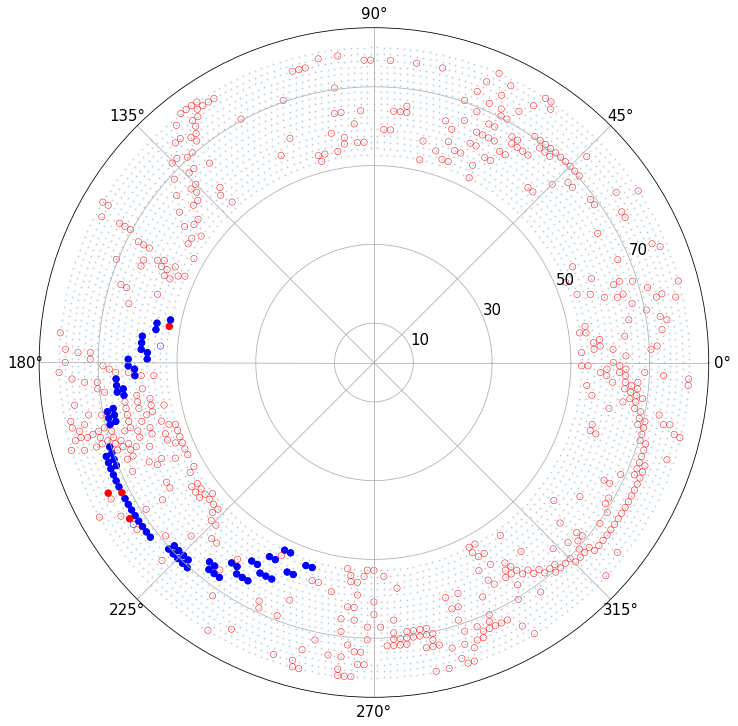

In [96]:
# Final
plot_output(to_plot, test_s.cdc.geom, size=plot_norm_size(test_s.cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True) > 0.298557))
plot_add_outlines(to_plot, test_s.cdc.geom)
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight', dpi=dpi)
show()

## Export the Data

In [97]:
export_name = "track_finding_sample_scored_2.root"

In [98]:
# Task 1 : Print signal only
# Task 2 : Print signal + background
len(hit_masks)

3

In [99]:
test_s.cdc.trim_hits(test_s.cdc.hits_index_name, 
                   values=test_s.cdc.data[hit_masks[1]][test_s.cdc.hits_index_name])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2113362 but corresponding boolean dimension is 1885826

In [100]:
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from rootpy.vector import LorentzVector
from rootpy import stl
from random import gauss, randint

# Map from python types to c++ types
type_dict_no_array = {dtype('float64'):"float", 
                      dtype('int32')  :"long",
                      dtype('int64')  :"long"}

type_dict_no_array = {dtype('float64'):"FloatCol()", 
                      dtype('int32')  :"IntCol()",
                      dtype('int64')  :"long"}

# Define the model of the output root file
class CDCTree(TreeModel):
    # Create a std::vector branch for each measurement
    for measure in test_s.cdc.data.dtype.names:
        this_dtype = type_dict[test_s.cdc.data.dtype[measure]]
        measure = measure.replace(".", "_")
        exec(measure + " = stl.vector(this_dtype)")
    # Delete branches we do not want
    del measure, this_dtype

# Open the output file
with root_open(savedir+export_name, mode='recreate') as output_file:
    # Open a new tree
    output_tree = Tree("test", model=CDCTree)
    for event in range(test_s.cdc.n_events):
        if event%100 == 0:
            print(event)
        event_hits = test_s.cdc.get_events(event)
        for measure in event_hits.dtype.names:
            this_measure = event_hits[measure]
            for hit_val in this_measure:
                output_tree[measure.replace(".","_")].push_back(hit_val)
        output_tree.fill(reset=True)
    output_tree.write()

NameError: name 'type_dict' is not defined

In [ ]:
fpr, tpr, thresh = roc_curve(test_s.cdc.data["CDCHit.fIsSig"], 
          test_s.cdc.data[trk_scr_name])

In [ ]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print(tabulate(table, headers="firstrow"))

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=5)

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Integrate trigger signal in


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

In [ ]:
if load_test:
    _ , hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                                    only_hits=True, flatten=True)
    default = [[31.5, 34, 34.5, 2]]
    submatrices = []

    # TODO test with several radii
    for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
        # Try with default values
        hough = HoughSpace(CDC(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                           sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
else: 
    # Get the local score predictions
    test_s.cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(test_s.cdc.data[lcl_train_features]))[:,1]
    # Remove coincident hits
    remove_coincidence(test_s.cdc)
    # Get the neighbouring score predictions
    test_s.cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                [test_s.cdc.get_measurement(row_name, only_hits=True,flatten=True)]).T,
            columns=neigh_train_features))[:,1]
    # Get the hough results
    test_s.cdc.data[hgh_scr_name], hough_images = \
            hough_transformer.transform(test_s.cdc.get_measurement(ngh_scr_name, 
                                                                 only_hits=False, 
                                                                 flatten=False),
                                       only_hits=True, flatten=True)
    # Test it on the last set of data
    test_s.cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.edep_name) +\
                get_measurment_and_neighbours(test_s.cdc, test_s.cdc.time_name) +\
                [test_s.cdc.get_measurement(row_name, only_hits=True,flatten=True)] +\
                [test_s.cdc.get_measurement(hgh_scr_name, only_hits=True,flatten=True)]).T,
            columns=track_train_features)
        )[:,1]

In [ ]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train.cdc, train.cdc.edep_name, evt_samp[1]) +\
                    get_measurment_and_neighbours(train.cdc, train.cdc.time_name, evt_samp[1]) +\
                    [train.cdc.get_measurement(row_name, evt_samp[1], only_hits=True,flatten=True)]).T,
                columns=neigh_train_features), 
            train.cdc.get_measurement(train.cdc.hit_type_name, evt_samp[1], only_hits=True,flatten=True))
pass

In [ ]:
# Print these predictions
train.cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train.cdc, train.cdc.edep_name) +\
            get_measurment_and_neighbours(train.cdc, train.cdc.time_name) +\
            [train.cdc.get_measurement(row_name, only_hits=True,flatten=True)]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train.cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

In [ ]:
plot_roc_curve(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(ngh_scr_name, 
                                         events=evt_samp[2],
                                         only_hits=True), 
               zoom=True, label="Neighbour ROC Curve")
print(roc_auc_score(train.cdc.get_measurement(train.cdc.hit_type_name, 
                                         events=evt_samp[2],
                                         only_hits=True), 
               train.cdc.get_measurement(ngh_scr_name, 
                                         events=evt_samp[2],
                                         only_hits=True)))
plt.show()